In [1]:
from google.colab import drive
 
# Accessing My Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install hazm
!pip install tqdm

from tqdm import tqdm
import numpy as np
import cv2 as cv
import pandas as pd
from hazm import *
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
import math
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score
import matplotlib.pyplot as plt
from string import punctuation
import random

     |████████████████████████████████| 316 kB 5.2 MB/s 
     |████████████████████████████████| 1.4 MB 25.9 MB/s 
     |████████████████████████████████| 233 kB 39.2 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394486 sha256=c0d036c12061fa078c5fac9e3f29860d6c04bd6b46d83e3784d9bae33bef8e93
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154687 sha256=5acc37a791cc90afebf97895996504d4c45c88a50a6b27e715fbe9ced2545867
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


# Load Data

The data is from digikala contest, and it consists of comments made by users. The aim is to predict wether a comment is a spam or non-spam comment. 
This dataset has 160000 records for train and 20000 records for test. 
I only use 8000 records from trainSet, and split them for creating my own X_train and X_test.

Here are the link to my dataset

train dataset : https://drive.google.com/file/d/18PSMJoPB_j45zGVOnCmryKLSJhw0_htI/view?usp=sharing

test dataset : https://drive.google.com/file/d/17vm0BbuJUrYCAIqB-anVhKFqNPSirlNL/view?usp=sharing

In [3]:
url = '/content/drive/MyDrive/Colab Notebooks/master/term1/nlp/train.csv'
df = pd.read_csv(url, engine='python',encoding='utf-8', error_bad_lines=False)
test_url = '/content/drive/MyDrive/Colab Notebooks/master/term1/nlp/test.csv'
df_test = pd.read_csv(test_url, engine='python',encoding='utf-8', error_bad_lines=False)

In [4]:
df[df['verification_status']!=0]

,id,title,comment,rate,verification_status
40216,60216,شامپو فیروز,راضی بودم، به خصوص در شگفت انگیز ارزش خرید داره,60.0,1
40219,60219,عدم تطابق تصویر با محصول ارسالی یک گلس کاملا م...,یک گلس کاملا معمولی که از هر طرف چند میل فاصله...,40.0,1
40225,60225,انتقاد از تامین کننده,متاسفانه حتی بعد از یکبار مرجوع کردن کالا بدلی...,60.0,1
40228,60228,دوستان ایا این تیغ ۴ لبه به دسته ۶تیغ لبه میخوره؟,دوستان ایا این تیغ ۴ لبه به دسته ۶تیغ لبه میخوره؟,60.0,1
40235,60235,افتضاح,من این ریمل رو همیشه استفاده میکنم و همیشه از ...,20.0,1
...,...,...,...,...,...
159968,179968,یعنی چی ؟,قیمت درسته ؟ ۲۶۰ هزارتومان ؟ یعنی ایقد پول بی ...,15.0,1
159970,179970,تالفببتن,خولبببوکگا,0.0,1
159978,179978,زخمی بودن کالا و بسته بندی ضعیف,برای مادرم خریدم وقتی براش کادو بردم و ضربه گی...,0.0,1
159983,179983,افتضاه,مرگ بر دی جی کالا,0.0,1


In [5]:
df.dropna(subset=['comment', 'verification_status'], inplace=True)

In [6]:
train_len = df.shape[0]
print(train_len)

159891


In [7]:
# I only use 5000 data for computation
df=df.sample(frac=0.05)
print(len(df))

7995


In [8]:
df_test.head()

,id,title,comment,rate
0,18053,جنس تاریخ گذشته و فاسد شده,جنس تاریخ گذشته بود.حدود دو هفته می گذشت از ان...,0.0
1,5088,کیفیت بسیار پایین,من این محصول را امروز از دیجی کالا تحویل گرفتم...,25.0
2,2264,خوب نیست,اصلا خوب نیست، فقط در این حد خوبه که گوشی خامو...,14.0
3,3352,بدنه ضعیف,کلا دو بار استفاده کردم بدنه مخزن شکست,64.0
4,10928,مناسب برای لباسشویی,فقط برای لباسشویی خوب است و در ظرفشویی بعد از ...,0.0


# Preprocessing

In [ ]:
normalizer = Normalizer()
lemmatizer = Lemmatizer()
stemmer = Stemmer()

stop_words= []
with open("/content/drive/MyDrive/Colab Notebooks/master/term1/nlp/stopwords-fa.txt" ,encoding = 'utf-8' ) as f:
    stop_words = f.read().splitlines()
stopwords = stop_words [1:]
print(stopwords)


def preprocessing(text):
    # print(text)
    cleared_text = []
    if not pd.isnull(text):
      text = re.sub(r'\d+', '', text)
      text = re.sub(r'\s*[A-Za-z]+\b', '', text)
      text = normalizer.normalize(text)
      tokens = word_tokenize(text)
      tokens = [word for word in tokens if not word in stopwords]
      cleared_text = tokens
    return cleared_text

def clean_text(all_texts):
  output = []
  i = 0
  for text in tqdm(all_texts):
    # if(i % 1000 == 0):
      # print("iteration # {}".format(i))
    i += 1
    clean_txt = preprocessing(text)
    output.append(clean_txt)
  return output

['؛', '۰', '۱', '۲', '۳', '۴', '۵', '۶', '۷', '۸', '۹', 'در', 'به', 'از', 'كه', 'مي', 'اين', 'را', 'با', 'آن', 'يك', 'کی', 'یا', 'من', 'و']


In [ ]:
preprocessed_text_train = clean_text(df['comment'])

100%|██████████| 8000/8000 [00:01<00:00, 4939.14it/s]


In [ ]:
preprocessed_text_test = clean_text(df_test['comment'])

100%|██████████| 20000/20000 [00:03<00:00, 5275.71it/s]


In [ ]:
# calculate the length of comments based on their words
df['comment_len_by_words'] = df['comment'].apply(lambda t: len(word_tokenize(t)))

In [ ]:
min_max_len = df["comment_len_by_words"].min(), df["comment_len_by_words"].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Min: 1 	Max: 957


In [ ]:
len(df[df["comment_len_by_words"]>100])

383

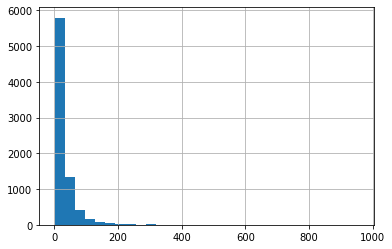

In [ ]:
pd.Series(df["comment_len_by_words"]).hist(bins = 30)

# Approch one

## Word Embedding

In the first approch I use TF_IDF technique for embedding. It is said that tf-idf embedding has a great performace on models such as NB. 
This statistical method indicated that how relevant a word is to a document in a collection of documents. We want to ignore words that are highly(treshold) frequent as well as those that appear rarely in dataset.

In [ ]:
def dummy_fun(doc):
    return doc
def tfidf(data, ma = 0.6, mi = 0.0001):
    tfidf_vectorize = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
    max_df = ma,
    min_df = mi) 
    tfidf_data = tfidf_vectorize.fit_transform(data)
    return tfidf_data

In [ ]:
word_embedded_text_train = tfidf(preprocessed_text_train)
print(word_embedded_text_train.shape)

word_embedded_text_test = tfidf(preprocessed_text_test)
print(word_embedded_text_test.shape)

merge_train_test = preprocessed_text_train
for i in range(0 , len(preprocessed_text_test)):
    merge_train_test.append(preprocessed_text_test[i])
merge_word_embedded_text = tfidf(merge_train_test)

(8000, 17198)
(20000, 12762)


## Split data

In [23]:
import sklearn
def train_test_spiliting(X,Y):
  x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size = 0.2, random_state = 42)
  print("X_train lenght: {}".format(x_train.shape[0]))
  print("X_test lenght: {}".format(x_test.shape[0]))
  return x_train, x_test, y_train, y_test 


In [10]:
def train_test_val_spiliting(X,Y):
  x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

  x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(x_train, y_train, test_size=0.25, random_state=42) 
  print("X_train lenght: {}".format(x_train.shape[0]))
  print("X_test lenght: {}".format(x_test.shape[0]))
  print("X_val lenght: {}".format(x_val.shape[0]))
  return x_train, x_test, x_val, y_train, y_test , y_val


In [ ]:
len(preprocessed_text_train)

28000

In [ ]:
x_train, x_test, y_train, y_test = train_test_spiliting(word_embedded_text_train , df['verification_status'])

X_train lenght: 6400
X_test lenght: 1600


## Model

I propose to models : logesticRegression , MultinomialNB

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from tensorflow.keras.callbacks import ReduceLROnPlateau
def model(x_train, x_test, y_train, y_test, model_name):
    if model_name == "LogisticRegression":
      model = Pipeline([ ('clf', LogisticRegression(n_jobs = 1 , C = 1e5))])
    elif model_name == "MultinomialNB":
      model = MultinomialNB()
    classifier = model.fit(x_train,y_train)
    predictions = classifier.predict(x_test)
    print(classification_report(y_test, predictions))
    a = accuracy_score(y_test, predictions)
    p = precision_score(y_test, predictions, average = 'weighted')
    r = recall_score(y_test, predictions, average = 'weighted')
    return a , p, r ,classifier

In [ ]:
def train(x_train, x_test, y_train, y_test,model_name):
  accuracy, precision, recall , classifier = model(x_train, x_test, y_train, y_test,model_name)
  print("model accuracy {}".format(accuracy))
  print("model precision {}".format(precision))
  print("model recall {}".format(recall))
  return classifier


### LogisticRegression

In [ ]:
classifier = train(x_train, x_test, y_train, y_test,'LogisticRegression')

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      1420
           1       0.44      0.53      0.48       180

    accuracy                           0.87      1600
   macro avg       0.69      0.72      0.70      1600
weighted avg       0.88      0.87      0.88      1600

model accuracy 0.87125
model precision 0.8830977243457826
model recall 0.87125


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### MultinomialNB

In [ ]:
classifier = train(x_train, x_test, y_train, y_test,'MultinomialNB')

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1420
           1       0.00      0.00      0.00       180

    accuracy                           0.89      1600
   macro avg       0.44      0.50      0.47      1600
weighted avg       0.79      0.89      0.83      1600

model accuracy 0.8875
model precision 0.78765625
model recall 0.8875


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

The results show that this model has the accuracy of 86%, although it is less than that obtained by MultinomialNB, it has higher precision for class 1 in comparison.
Also, logestic regression is a model widely used for multiclassification, while MultinomialNB is a multinomial Naive Bayes classifier.
Naive Bayes model was taught at the class.
logestic regression is used for categorical targets, it computes Z = WX + B and then apply sigmoid function on z. If Z goes to infinity, Y(predicted) will become 1 and if Z goes to negative infinity, Y(predicted) will become 0. And it uses mean squared error as its cost function.
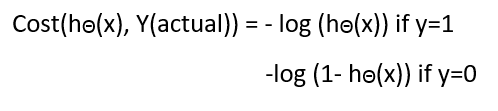

# Second approach

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, GRU
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import tensorflow as tf


MAX_LEN = 100
embed_dim = 256
LSTM_UNIT = 196
GRU_UNIT = 196
batch_size = 16
VOCAB_SIZE = 20000
OUTPUT_PATH_DL_MODEL = '/content/drive/MyDrive/Colab Notebooks/master/term1/nlp/digikala/digikala_model'

## Preprocessing

First, I tokenize the trainset using keras Tokenizer, also, I set the max number of words to 4000

In [17]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_LEN, split=' ')
df.dropna(subset = ["comment"], inplace=True)
tokenizer.fit_on_texts(df['comment'].values)

In [18]:
X = tokenizer.texts_to_sequences(df['comment'].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X)
print("the input shape is {}".format(X.shape))

the input shape is (7995, 354)


In [19]:
Y = pd.get_dummies(df['verification_status'])

In [20]:
len(df['verification_status'])

7995

In [21]:
len(Y)

7995

## Split

In [24]:
X_train, X_test,_, Y_train, Y_test,_ = train_test_val_spiliting(X,Y)
# print(X_train.shape,Y_train.shape)

X_train lenght: 4797
X_test lenght: 1599
X_val lenght: 1599


## Model - BILSTM

Here, I use a form of RNN called LSTM followed by a dense layer to predict the two classes.  Note that for Simplifying the mode we can use GRU(output, state_h) as it has 2 gates while lstm has 3 gates(output, state_h, state_c). For improving the performace of the model we can make it Bidirectional by changing the model to : model.add(Bidirectional(LSTM(LSTM_UNIT, dropout=0.2, recurrent_dropout=0.2)))

LSTMs also have multiple single cell connect to eachother like a chain, the repeating module has four NN layer, interacting in a very special way. A special part of this model is that the cell state is running through all the modules,  and LSTM remove or add information to the cell state.
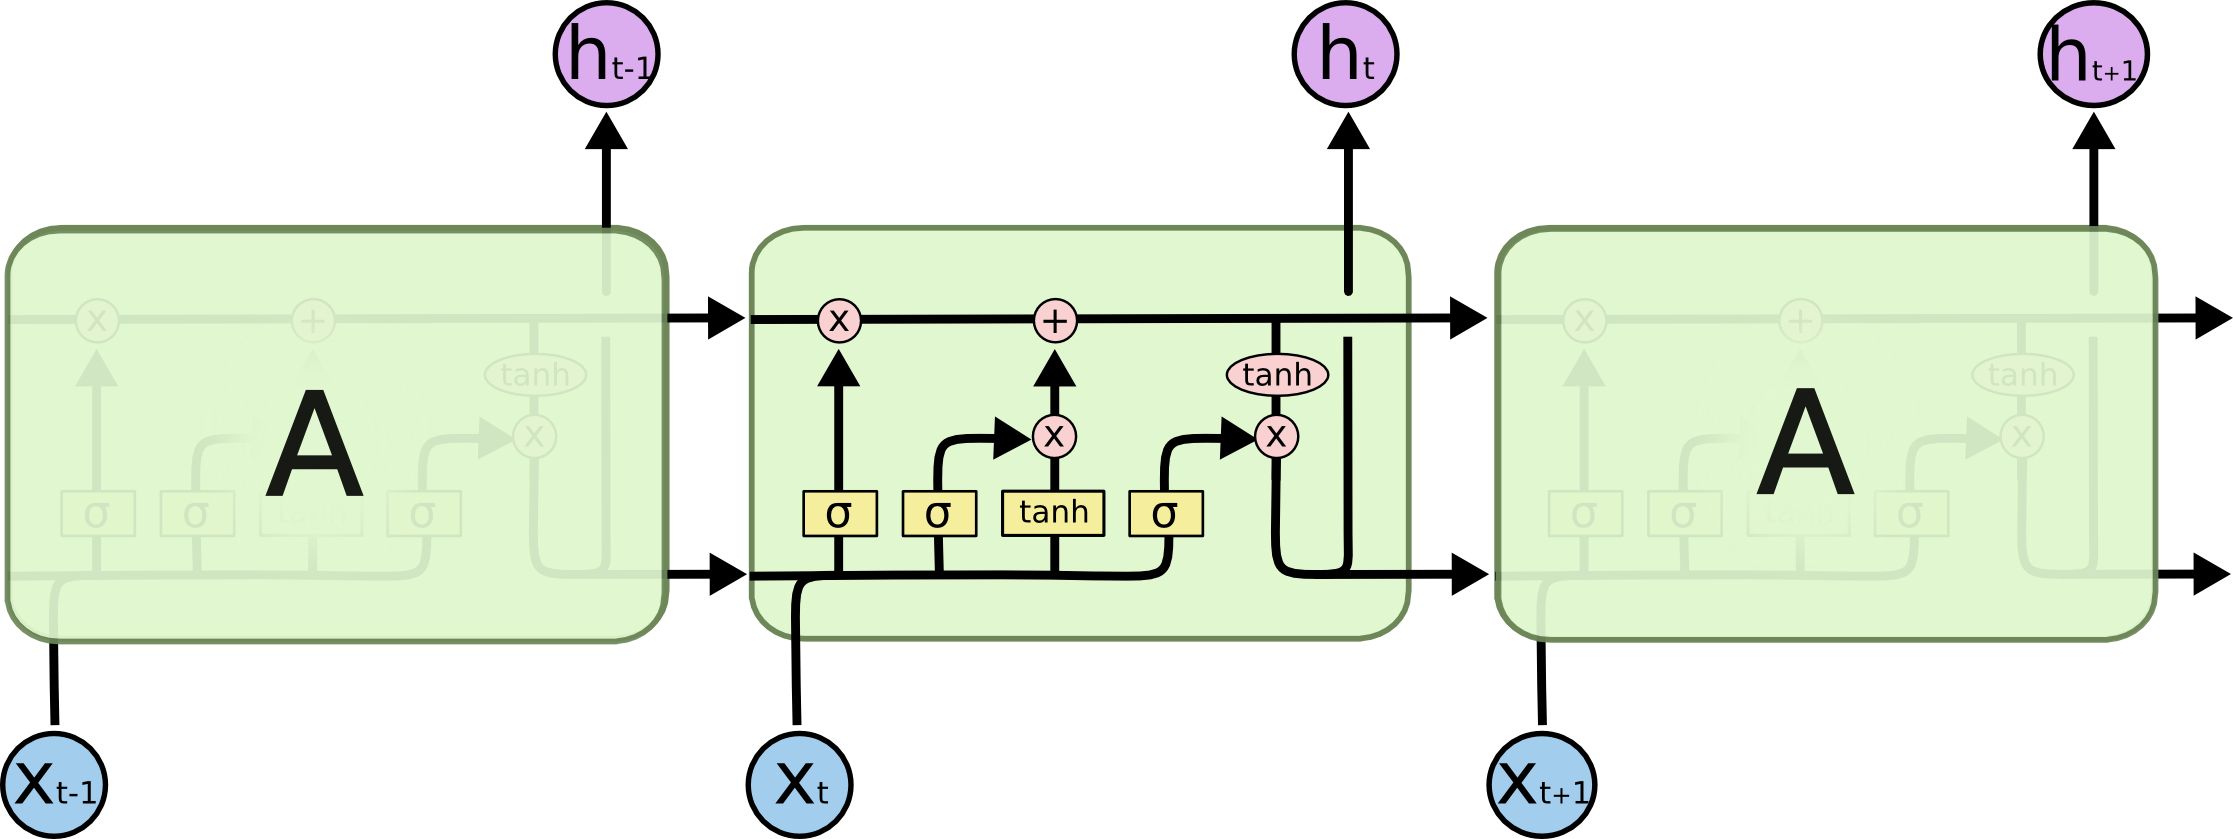

In [40]:
model = Sequential()
model.add(Embedding(MAX_LEN, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(LSTM_UNIT, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = [tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 354, 256)          25600     
                                                                 
 spatial_dropout1d_8 (Spatia  (None, 354, 256)         0         
 lDropout1D)                                                     
                                                                 
 lstm_8 (LSTM)               (None, 196)               355152    
                                                                 
 dense_8 (Dense)             (None, 2)                 394       
                                                                 
Total params: 381,146
Trainable params: 381,146
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
model.fit(X_train, Y_train,batch_size=batch_size, epochs = 3, verbose = 1)

Epoch 1/3
300/300 [==============================] - 658s 2s/step - loss: 0.3679 - precision_1: 0.8724 - recall_1: 0.8724 - accuracy: 0.8724
Epoch 2/3
300/300 [==============================] - 624s 2s/step - loss: 0.3328 - precision_1: 0.8795 - recall_1: 0.8795 - accuracy: 0.8795
Epoch 3/3
300/300 [==============================] - 631s 2s/step - loss: 0.3242 - precision_1: 0.8793 - recall_1: 0.8793 - accuracy: 0.8793


In [42]:
model.save(OUTPUT_PATH_DL_MODEL+'BILSTM.pt')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/master/term1/nlp/digikala/digikala_modelBILSTM.pt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/master/term1/nlp/digikala/digikala_modelBILSTM.pt/assets


I could not train the model completely as RNN models take alot of time to be trained, however the accuracy obtained by such models is higher than NN based models because, LSTM memorizing certain patterns and have multiple hidden layers and as it passes through every layer, the relevant information is kept and all the irrelevant information gets discarded in every single cell. This happens as it has forget gate and cell state along with input/output gate. 

In [44]:
print(model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size))
# print("accuracy: {}" .format(acc))

100/100 - 20s - loss: 0.3351 - precision_1: 0.8718 - recall_1: 0.8718 - accuracy: 0.8718 - 20s/epoch - 196ms/step
[0.3351120054721832, 0.8717948794364929, 0.8717948794364929, 0.8717948794364929]


## Model - BIGRU

In [46]:
model = Sequential()
model.add(Embedding(MAX_LEN, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(GRU(GRU_UNIT, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics =[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy'])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 354, 256)          25600     
                                                                 
 spatial_dropout1d_10 (Spati  (None, 354, 256)         0         
 alDropout1D)                                                    
                                                                 
 gru_1 (GRU)                 (None, 196)               266952    
                                                                 
 dense_10 (Dense)            (None, 2)                 394       
                                                                 
Total params: 292,946
Trainable params: 292,946
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
model.fit(X_train, Y_train,batch_size=batch_size, epochs = 3, verbose = 1)

Epoch 1/3
300/300 [==============================] - 652s 2s/step - loss: 0.3665 - precision_2: 0.8716 - recall_2: 0.8716 - accuracy: 0.8716
Epoch 2/3
300/300 [==============================] - 612s 2s/step - loss: 0.3312 - precision_2: 0.8776 - recall_2: 0.8776 - accuracy: 0.8776
Epoch 3/3
300/300 [==============================] - 622s 2s/step - loss: 0.3216 - precision_2: 0.8791 - recall_2: 0.8791 - accuracy: 0.8791


In [48]:
model.save(OUTPUT_PATH_DL_MODEL+'BIGRU.pt')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/master/term1/nlp/digikala/digikala_modelBIGRU.pt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/master/term1/nlp/digikala/digikala_modelBIGRU.pt/assets


In [50]:
print(model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size))

100/100 - 35s - loss: 0.3227 - precision_2: 0.8806 - recall_2: 0.8806 - accuracy: 0.8806 - 35s/epoch - 348ms/step
[0.32269713282585144, 0.8805503249168396, 0.8805503249168396, 0.8805503249168396]


# Third approach

## Attention

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GRU, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, Concatenate, Dropout, Attention
from numpy import array

In [ ]:
class Attention(keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

## Model - BILSTM with attention

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 357)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 357, 128)     2560128     ['input_1[0][0]']                
                                                                                                  
 bi_lstm_0 (Bidirectional)      (None, 357, 392)     509600      ['embedding[0][0]']              
                                                                                                  
 bi_lstm_1 (Bidirectional)      [(None, 357, 392),   923552      ['bi_lstm_0[0][0]']              
                                 (None, 196),                                                 

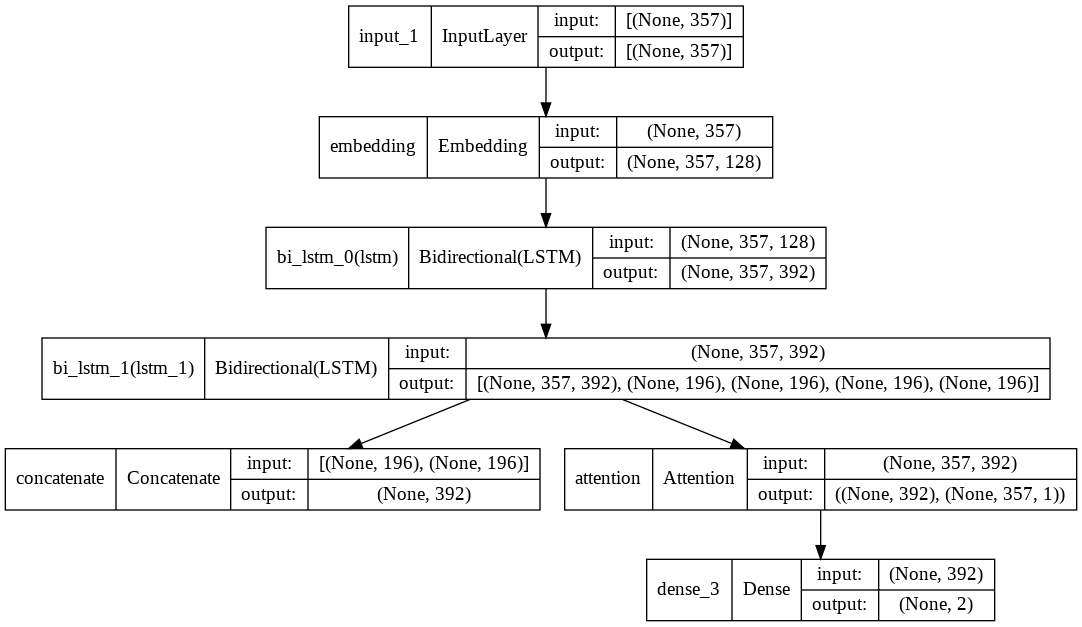

In [ ]:
enc_inp = Input(shape=(X.shape[1],), dtype="int32")
enc_embed = Embedding(VOCAB_SIZE+1, 128, mask_zero=True, input_length=X.shape[1])(enc_inp)
lstm = Bidirectional(LSTM(LSTM_UNIT, return_sequences = True), name="bi_lstm_0")(enc_embed)
# enc_lstm = Bidirectional(LSTM(LSTM_UNIT, return_state=True, dropout=0.05, return_sequences = True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(LSTM_UNIT, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
enc_states_1 = [state_h, state_c]


context_vector, attention_weights = Attention(10)(encoder_outputs, state_h)

output = Dense(2, activation='softmax')(context_vector)

model = Model(inputs=enc_inp, outputs=output)

# summarize layers
print(model.summary())

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)


In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [ ]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        min_delta=0,
                                                        patience=1,
                                                        verbose=0, mode='auto')

In [ ]:
model.fit(X_train, Y_train,batch_size=batch_size, epochs = 3, verbose = 1, callbacks=[early_stopping_callback])

Epoch 1/3
400/400 [==============================] - 2830s 7s/step - loss: 0.3578 - accuracy: 0.8738
Epoch 2/3
400/400 [==============================] - 2742s 7s/step - loss: 0.2761 - accuracy: 0.8791
Epoch 3/3
400/400 [==============================] - 2740s 7s/step - loss: 0.2641 - accuracy: 0.8946


In [ ]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("accuracy: {}" .format(acc))

100/100 - 125s - loss: 0.3391 - accuracy: 0.8268 - 125s/epoch - 1s/step
accuracy: 0.8267667293548584


## Model - BIGRU with attention

In [ ]:
enc_inp = Input(shape=(X.shape[1],), dtype="int32")
enc_embed = Embedding(VOCAB_SIZE+1, 128, mask_zero=True, input_length=X.shape[1])(enc_inp)
lstm = Bidirectional(GRU(LSTM_UNIT, return_sequences = True), name="bi_lstm_0")(enc_embed)
# enc_lstm = Bidirectional(LSTM(LSTM_UNIT, return_state=True, dropout=0.05, return_sequences = True))
encoder_outputs, forward_h, backward_h = Bidirectional(GRU(LSTM_UNIT, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)
state_h = Concatenate()([forward_h, backward_h])
enc_states_1 = [state_h, state_c]


context_vector, attention_weights = Attention(10)(encoder_outputs, state_h)

output = Dense(2, activation='softmax')(context_vector)

model = Model(inputs=enc_inp, outputs=output)

# summarize layers
print(model.summary())

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 357)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 357, 128)     2560128     ['input_4[0][0]']                
                                                                                                  
 bi_lstm_0 (Bidirectional)      (None, 357, 392)     383376      ['embedding_3[0][0]']            
                                                                                                  
 bi_lstm_1 (Bidirectional)      [(None, 357, 392),   693840      ['bi_lstm_0[0][0]']              
                                 (None, 196),                                               

In [ ]:
model.fit(X_train, Y_train,batch_size=batch_size, epochs = 3, verbose = 1)

Epoch 1/3
300/300 [==============================] - 1505s 5s/step - loss: 0.3708 - accuracy: 0.8770
Epoch 2/3
300/300 [==============================] - 1450s 5s/step - loss: 0.3178 - accuracy: 0.8797
Epoch 3/3
300/300 [==============================] - 1445s 5s/step - loss: 0.3108 - accuracy: 0.8797


In [ ]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("accuracy: {}" .format(acc))

100/100 - 53s - loss: 0.3611 - accuracy: 0.8587 - 53s/epoch - 531ms/step
accuracy: 0.8586616516113281


# Fourth approach

## PyTorch

In [ ]:
! pip install transformers
from transformers import BertConfig, BertTokenizer, AutoModel
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import re
import json

### Configuration

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [ ]:
# general config
MAX_LEN = 100
BATCH_SIZE = 32
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 10
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME= 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/drive/MyDrive/Colab Notebooks/master/term1/nlp/digikala/digikala_model.pt'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
# setup the tokenizer and configuration

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
config = BertConfig.from_pretrained(
    MODEL_NAME)

print(config.to_json_string())

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



In [ ]:
config.num_labels

2

### split

In [ ]:
X_train, X_test, X_val, Y_train, Y_test, Y_val = train_test_val_spiliting(df['comment'],df['verification_status'])

X_train lenght: 4797
X_test lenght: 1599
X_val lenght: 1599


### Embedding

In [ ]:
sample_comment = X_train[154793]
sample_label = Y_train[154793]

print(f'Sample: \n{sample_comment}\n{sample_label}')

Sample: 
با خرید شگفت انگیزش موافقم.
0


In [ ]:
tokens = tokenizer.tokenize(sample_comment)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'  Comment: {sample_comment}')
print(f'   Tokens: {tokenizer.convert_tokens_to_string(tokens)}')
print(f'Token IDs: {token_ids}')

  Comment: با خرید شگفت انگیزش موافقم.
   Tokens: با خرید شگفت انگیزش موافقم .
Token IDs: [2799, 3535, 6602, 26647, 39015, 1012]


In [ ]:
encoding = tokenizer.encode_plus(
    sample_comment,
    max_length = MAX_LEN,
    pad_to_max_length=True,
    truncation=True
)

print(f'Keys: {encoding.keys()}\n')
for k in encoding.keys():
    print(f'{k}:\n{encoding[k]}')

Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids:
[2, 2799, 3535, 6602, 26647, 39015, 1012, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
token_type_ids:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask:
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


### Dataloader

In [ ]:
def create_dataloader(data, label):
  tokens_data = tokenizer.batch_encode_plus(
    data.tolist(),
    max_length = MAX_LEN,
    pad_to_max_length=True,
    truncation=True,
    # return_token_type_ids=True,
    # padding='max_length',
    return_attention_mask=True,
    # return_tensors='pt'
)
  data_seq = torch.tensor(tokens_data['input_ids'])
  data_mask = torch.tensor(tokens_data['attention_mask'])
  data_y = torch.tensor(label.tolist())

  # wrap tensors
  wrap_data = TensorDataset(data_seq, data_mask, data_y)

  # sampler for sampling the data during training
  data_sampler = RandomSampler(wrap_data)

  # dataLoader for train set
  dataloader = torch.utils.data.DataLoader(wrap_data, sampler=data_sampler, batch_size=BATCH_SIZE)

  return dataloader, tokens_data


In [ ]:
train_dataloader, tokens_train = create_dataloader(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
test_dataloader, tokens_test = create_dataloader(X_test, Y_test)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
val_dataloader, tokens_val = create_dataloader(X_val, Y_val)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
sample_data = next(iter(train_dataloader))
print(sample_data)

[tensor([[    2, 13110,  5402,  ...,  2800, 22367,     4],
        [    2,  5668,  8629,  ...,     0,     0,     0],
        [    2,  4589,  8188,  ...,     0,     0,     0],
        ...,
        [    2,  2789, 11053,  ...,     0,     0,     0],
        [    2,  4219,  8745,  ...,     0,     0,     0],
        [    2, 38334,  8474,  ...,     0,     0,     0]]), tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), tensor([0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])]


### Model 

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

!nvidia-smi

Sat Jan  1 16:59:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# import BERT-base pretrained model
bert = BertModel.from_pretrained(MODEL_NAME, return_dict=False)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_model(nn.Module):

    def __init__(self, bert):
      
      super(BERT_model, self).__init__()

      self.bert = bert 
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,2)
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)

      return x


In [ ]:
model = BERT_model(bert)
model = model.to(device)

In [ ]:
params = list(model.named_parameters())
print('The Bert model has {:} different named parameters. \n'.format(len(params)))

The Bert model has 203 different named parameters. 



In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

### Train function

In [ ]:
# train the model for one epoch
def train(train_dataloader):
  
  model.train()

  total_loss, total_accuracy = 0, 0
 
  total_preds=[]

  for step,batch in enumerate(train_dataloader):
    
    if step % 100 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    batch = [r.to(device) for r in batch]
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(batch[0].to(device), batch[1].to(device))
    loss = cross_entropy(preds, batch[2].to(device))
    total_loss = total_loss + loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    preds=preds.detach().cpu().numpy()
    total_preds.append(preds)

  avg_loss = total_loss / len(train_dataloader)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds


### Validation function

In [ ]:
# evaluating the model for onr epoch
def evaluate(val_dataloader):

  model.eval()

  total_loss, total_accuracy = 0, 0

  total_preds = []

  for step,batch in enumerate(val_dataloader):
  
    if step % 100 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    batch = [t.to(device) for t in batch]

    with torch.no_grad():
      
      preds = model(batch[0].to(device), batch[1].to(device))
      loss = cross_entropy(preds,batch[2].to(device))
      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  avg_loss = total_loss / len(val_dataloader) 
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

### Taining the model

In [ ]:
def training_the_model(train_dataloader,val_dataloader,epochs):
  best_valid_loss = float('inf')

  train_losses=[]
  valid_losses=[]

  for epoch in range(epochs):
      
      print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
      
      train_loss, _ = train(train_dataloader)

      valid_loss, _ = evaluate(val_dataloader)
      
      #save model
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(),OUTPUT_PATH)
    
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      
      print('\nTraining Loss: {}'.format(train_loss))
      print('Validation Loss: {}'.format(valid_loss))
      print("#"*20)

In [ ]:
training_the_model(train_dataloader,val_dataloader,EPOCHS)


 Epoch 1 / 10
  Batch   100  of    150.

Training Loss: 0.5722006227572759
Validation Loss: 0.5460432094335556
####################

 Epoch 2 / 10
  Batch   100  of    150.

Training Loss: 0.5530822608868281
Validation Loss: 0.5403047460317612
####################

 Epoch 3 / 10
  Batch   100  of    150.

Training Loss: 0.5377244261900583
Validation Loss: 0.5342468559741974
####################

 Epoch 4 / 10
  Batch   100  of    150.

Training Loss: 0.5366067852576574
Validation Loss: 0.5248927062749863
####################

 Epoch 5 / 10
  Batch   100  of    150.

Training Loss: 0.5280563648541768
Validation Loss: 0.5255464988946915
####################

 Epoch 6 / 10
  Batch   100  of    150.

Training Loss: 0.5189530223608017
Validation Loss: 0.5111493104696274
####################

 Epoch 7 / 10
  Batch   100  of    150.

Training Loss: 0.5160678664843241
Validation Loss: 0.5240819397568702
####################

 Epoch 8 / 10
  Batch   100  of    150.

Training Loss: 0.5137577497

### Load saved model

In [ ]:
model.load_state_dict(torch.load(OUTPUT_PATH))

<All keys matched successfully>

### Prediction

In [ ]:
with torch.no_grad():
  test_seq = torch.tensor(tokens_test['input_ids'])
  test_mask = torch.tensor(tokens_test['attention_mask'])
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

           0       0.95      0.79      0.86      1382
           1       0.35      0.72      0.47       217

    accuracy                           0.78      1599
   macro avg       0.65      0.76      0.67      1599
weighted avg       0.87      0.78      0.81      1599

